In [1]:
import collections

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

import classy

import pyccl as ccl

The set of common cosmological parameters. The standard integration stepsize is insufficient at very low redshift (z=0.01) when agreement with CCL at the 1e-5 level is required. We thus set `back_integration_stepsize` to something lower.

In [2]:
class_params = {"output"    : "",
                "T_cmb"     : 2.725,
                "h"         : 0.7,
                "Omega_cdm" : 0.25,
                "Omega_b"   : 0.05,
                "A_s"       : 2e-9,
                "n_s"       : 1.0,
                # "w0_fld"    : -1.0,
                # "wa_fld"    : 0.0,
                "back_integration_stepsize" : 1.0e-3, # Required for agreement at <1e-5 with CCL.
               }

Define a set of models with different curvature and number of neutrinos (both massless and massive).

In [3]:
models = [("flat_nonu",         {"Omega_k"  : 0.0,
                                 "N_ur"     : 3.0}),
          ("pos_curv_nonu"    , {"Omega_k"  : 0.01,
                                 "N_ur"     : 3.0}),
          ("neg_curv_nonu"    , {"Omega_k"  : -0.01,
                                 "N_ur"     : 3.0}),
          ("flat_massnu1"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 2.0,         # 1 massive neutrino
                                 "N_ncdm"   : 1,           # 1 species
                                 "m_ncdm"   : 0.1}),        # Mass
          ("flat_massnu2"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 0.0,         # 3 massive neutrinos
                                 "N_ncdm"   : 2,           # 2 species
                                 "m_ncdm"   : "0.03, 0.1", # Masses
                                 "deg_ncdm" : "2, 1"}),     # Degeneracy
          ("flat_massnu3"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 0.0,               # 3 massive neutrinos
                                 "N_ncdm"   : 3,                 # 3 species
                                 "m_ncdm"   : "0.03, 0.05, 0.1", # Masses
                                 "deg_ncdm" : "1, 1, 1"}),        # Degeneracy
          ("flat_manynu1"     , {"Omega_k"  : 0.0,
                                 "N_ur"     : 6.0}),         # 6 massless neutrinos
          ("neg_curv_massnu1" , {"Omega_k"  : -0.01,
                                 "N_ur"     : 4.0,         # 4 massless neutrinos
                                 "N_ncdm"   : 2,           # 2 species of massive neutrinos
                                 "m_ncdm"   : "0.03, 0.1", # Masses
                                 "deg_ncdm" : "1, 1"}),     # Degeneracy
          ("pos_curv_manynu1" , {"Omega_k"  : 0.01,
                                 "N_ur"     : 3.0,               # 3 massless neutrinos
                                 "N_ncdm"   : 3,                 # 2 species of massive neutrinos
                                 "m_ncdm"   : "0.03, 0.05, 0.1", # Masses
                                 "deg_ncdm" : "1, 1, 1"}),        # Degeneracy
        ]

Run CLASS and get the comoving distances.

In [4]:
z = np.logspace(-1, 3, 50, endpoint=True)

d_ang = collections.OrderedDict()
d_ang_direct = collections.OrderedDict()
d_co = collections.OrderedDict()
z_class = collections.OrderedDict()

for (model_name, model) in models:
    print("Computing {}".format(model_name))

    cosmo = classy.Class()
    cosmo.set({**class_params, **model})
    cosmo.compute()

    z_class[model_name] = cosmo.get_background()["z"][:]
    d_co[model_name] = cosmo.get_background()["comov. dist."][:]
    d_ang[model_name] = cosmo.get_background()["ang.diam.dist."][:]

    d_ang_direct[model_name] = np.array([cosmo.angular_distance(x) for x in z])
    cosmo.struct_cleanup()

Computing flat_nonu
Computing pos_curv_nonu
Computing neg_curv_nonu
Computing flat_massnu1
Computing flat_massnu2
Computing flat_massnu3
Computing flat_manynu1
Computing neg_curv_massnu1
Computing pos_curv_manynu1


Check the interpolation error in z.

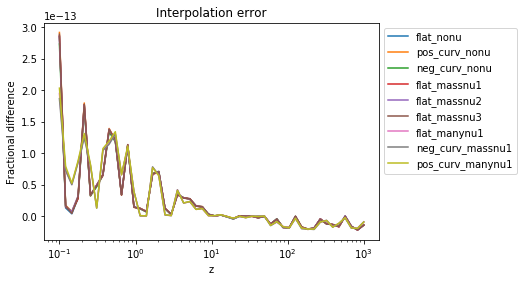

In [5]:
for model_name, da in d_ang.items():
    intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model_name][::-1], da[::-1])
    plt.plot(z, intp(z)/d_ang_direct[model_name] - 1, label=model_name)

plt.xscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("z")
plt.ylabel("Fractional difference")
_ =plt.title("Interpolation error")

Plot the angular diameter distance for the different models defined above.

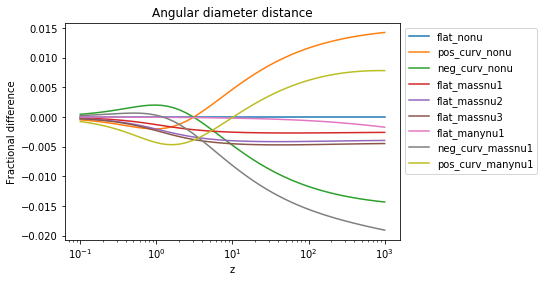

In [6]:
fid_model = "flat_nonu"
for model_name, da in d_ang.items():
    intp1 = scipy.interpolate.InterpolatedUnivariateSpline(z_class[fid_model][::-1], d_ang[fid_model][::-1])
    intp2 = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model_name][::-1], da[::-1])
    plt.plot(z, intp2(z)/intp1(z)-1, label=model_name)

plt.xscale("log")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel("z")
plt.ylabel("Fractional difference")
_ = plt.title("Angular diameter distance")

Create the benchmark file.

In [7]:
z_min = 0.01
z_max = 1050.0
n_z = 10
z_benchmark = np.logspace(np.log10(z_min), np.log10(z_max), n_z, endpoint=True)
#z_benchmark = np.insert(z_benchmark, 0, 0.0)

n_model = len(models)
chi_benchmark = np.zeros((n_z, n_model+1))
chi_benchmark[:,0] = z_benchmark

benchmark_file= "./chi_hiz_mnu_model{}-{}.txt".format(6, 6+n_model)

for i, (model_name, chi) in enumerate(d_co.items()):
    intp = scipy.interpolate.InterpolatedUnivariateSpline(z_class[model_name][::-1], chi[::-1])
    chi_benchmark[:,i+1] = intp(z_benchmark)

np.savetxt(benchmark_file, chi_benchmark, header="z " + "   ".join([name for (name, _) in models]))